# 🌲 Random Forest Model (Without Temp-R)

This notebook trains a Random Forest model to predict daily call volumes without relying on the temperature feature (`Temp-R`).  
The purpose is to evaluate model robustness when weather data is unavailable.

We will:
- Aggregate the data by date and topic
- Train the model without `Temp-R`
- Evaluate using MAE, RMSE, R²
- Visualize feature importances


In [9]:
# 📦 Load required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [10]:
# 📥 Load the cleaned dataset
data = pd.read_csv('../data/ready_for_models_final.csv')
print(f"✅ Data loaded! Shape: {data.shape}")


✅ Data loaded! Shape: (98095, 204)


In [11]:
# 🛠️ Define columns to group by (for daily granularity)
group_keys = []
group_keys += [col for col in data.columns if col.startswith('שנה_')]      # Year
group_keys += [col for col in data.columns if col.startswith('חודש_')]     # Month
group_keys += [col for col in data.columns if col.startswith('יום_')]      # Day of week
group_keys += [col for col in data.columns if col.startswith('נושא_')]     # Topic
group_keys += ['חג', 'Rain', 'Temp-R']  # Temp-R will be removed later from features

# 📊 Aggregate to daily level per topic
agg_daily_topic = data.groupby(group_keys).size().reset_index(name='calls_count')
print(f"✅ Aggregated shape: {agg_daily_topic.shape}")


✅ Aggregated shape: (31894, 114)


C:\Users\mevas\AppData\Local\Temp\ipykernel_27080\889693758.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agg_daily_topic = data.groupby(group_keys).size().reset_index(name='calls_count')
C:\Users\mevas\AppData\Local\Temp\ipykernel_27080\889693758.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agg_daily_topic = data.groupby(group_keys).size().reset_index(name='calls_count')
C:\Users\mevas\AppData\Local\Temp\ipykernel_27080\889693758.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resu

In [12]:
# ✂️ Define features (excluding Temp-R) and target
X = agg_daily_topic.drop(columns=['calls_count', 'Temp-R'])
y = agg_daily_topic['calls_count']


In [13]:
# 🧪 Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [14]:
# 🚀 Initialize and train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 📈 Predict on test set
y_pred_rf = rf_model.predict(X_test)


In [15]:
# 📊 Evaluate model using MAE, RMSE, and R²
mae = mean_absolute_error(y_test, y_pred_rf)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2 = r2_score(y_test, y_pred_rf)

print("=== Random Forest Without Temp-R Results ===")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.2f}")


=== Random Forest Without Temp-R Results ===
MAE: 1.71
RMSE: 3.25
R2 Score: 0.27


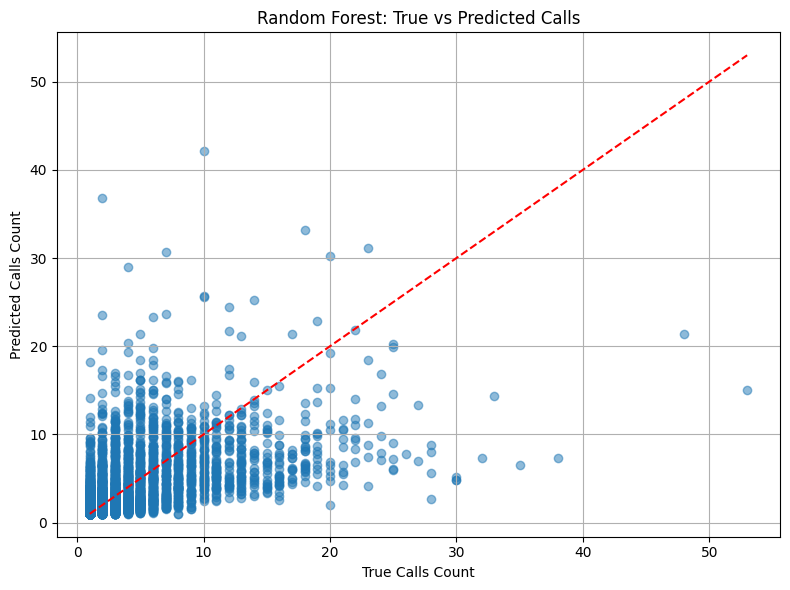

In [17]:
# 📈 Scatter plot: True vs Predicted (Random Forest)

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal reference line
plt.xlabel('True Calls Count')
plt.ylabel('Predicted Calls Count')
plt.title('Random Forest: True vs Predicted Calls')
plt.grid(True)
plt.tight_layout()
plt.show()


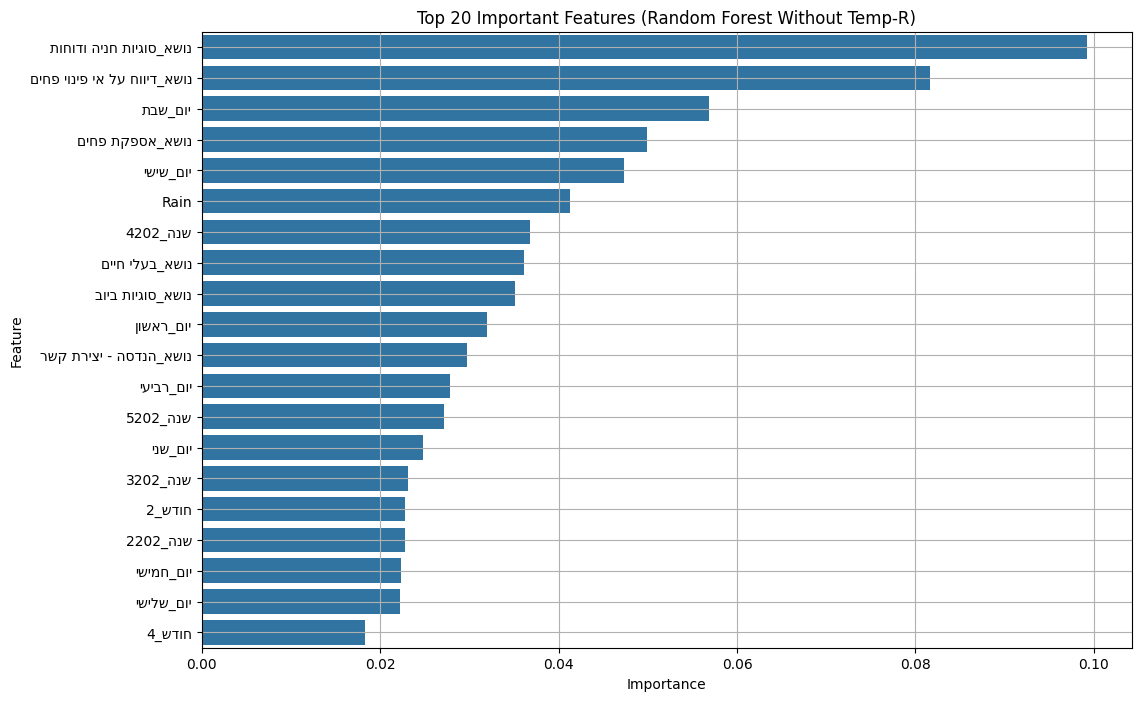

In [16]:
# 📋 Compute feature importances
importances = rf_model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 🪄 Reverse Hebrew labels only (to improve readability in plots)
def reverse_if_hebrew(text):
    return text[::-1] if any('\u0590' <= c <= '\u05FF' for c in text) else text

importance_df['Feature'] = importance_df['Feature'].apply(reverse_if_hebrew)

# 📈 Plot top features
plt.figure(figsize=(12,8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Top 20 Important Features (Random Forest Without Temp-R)')
plt.grid(True)
plt.show()
